# Vector similarity

コサイン類似度を用いて、2つのベクトルの類似度を測定することができます。 


In [1]:
# Load in vector embeddings for 1000 most common words
import json
    
with open('embeddings/words_text-embedding-ada-002.json') as f:
    vectors_ada2 = json.load(f)

with open('embeddings/words_text-embedding-3-small-1536.json') as f:
    vectors_emb3 = json.load(f)

with open('embeddings/words_text-embedding-3-large-3072.json') as f:
    vectors_emb3_large = json.load(f)

In [2]:
def cosine_similarity(v1, v2):

  dot_product = sum(
    [a * b for a, b in zip(v1, v2)])
  
  magnitude = (
    sum([a**2 for a in v1]) *
    sum([a**2 for a in v2])) ** 0.5

  return dot_product / magnitude

In [3]:
cosine_similarity(vectors_emb3['源頼朝'], vectors_emb3['合戦'])

0.18111330469103806

## Most similar words

コサイン類似度という尺度を使用して、任意の単語に最も類似した単語を見つけることができます。

In [4]:
import pandas as pd

def most_similar(word: str, vectors: dict) -> list[list]:
    """指定した単語に最も類似する10の単語と類似性を返す"""
    word_vector = vectors[word]
    similarities = {w: cosine_similarity(word_vector, vector) for w, vector in vectors.items()}
    most_similar_words = sorted(similarities, key=similarities.get, reverse=True)
    return pd.DataFrame([(word, similarities[word]) for word in most_similar_words[:10]], columns=['word', 'similarity'])


/Users/han/opt/anaconda3/envs/py1226/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
word = '壇ノ浦の戦い'
most_similar(word, vectors_ada2)

,word,similarity
0,壇ノ浦の戦い,1.000000
1,壇ノ浦合戦,0.972764
2,壇ノ浦,0.937191
3,一ノ谷の戦い,0.929862
4,屋島の戦い,0.922653
5,石橋山の戦い,0.922020
6,富士川の戦い,0.919750
7,戦い,0.883681
8,畠山重忠の乱,0.878520
9,参戦,0.872388


In [6]:
most_similar(word, vectors_emb3)

,word,similarity
0,壇ノ浦の戦い,1.000000
1,壇ノ浦合戦,0.933246
2,壇ノ浦,0.816887
3,一ノ谷の戦い,0.589789
4,富士川の戦い,0.583084
5,石橋山の戦い,0.536232
6,屋島の戦い,0.523991
7,戦い,0.506458
8,和田合戦,0.478601
9,戦勝,0.445120


In [7]:
most_similar(word, vectors_emb3_large)

,word,similarity
0,壇ノ浦の戦い,1.000000
1,壇ノ浦合戦,0.897214
2,壇ノ浦,0.794696
3,富士川の戦い,0.582407
4,石橋山の戦い,0.526529
5,一ノ谷の戦い,0.513314
6,屋島の戦い,0.473188
7,奥州合戦,0.448433
8,合戦,0.416923
9,承久の乱,0.410397


## 類似度空間の可視化

主成分分析（PCA）のような次元削減技術を使用して、単語ベクトルを2次元空間で可視化することができます。これにより、単語間の関係性や、それらがどのようにクラスタ化されるかを確認することができます。次元削減は非常に損失の多いプロセスであることに注意してください。

In [9]:
import numpy as np
from sklearn.decomposition import PCA


def perform_pca(vectors: dict):
    """単語ベクトルに対して主成分分析を行い、主成分分析で変換されたベクトルを返す"""
    X = np.array(list(vectors.values()))
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    X_pca = {list(vectors.keys())[i]: X_pca[i] for i in range(len(vectors))}
    return X_pca


vectors_ada2_pca = perform_pca(vectors_ada2)
vectors_emb3_pca = perform_pca(vectors_emb3)
vectors_emb3_large_pca = perform_pca(vectors_emb3_large)

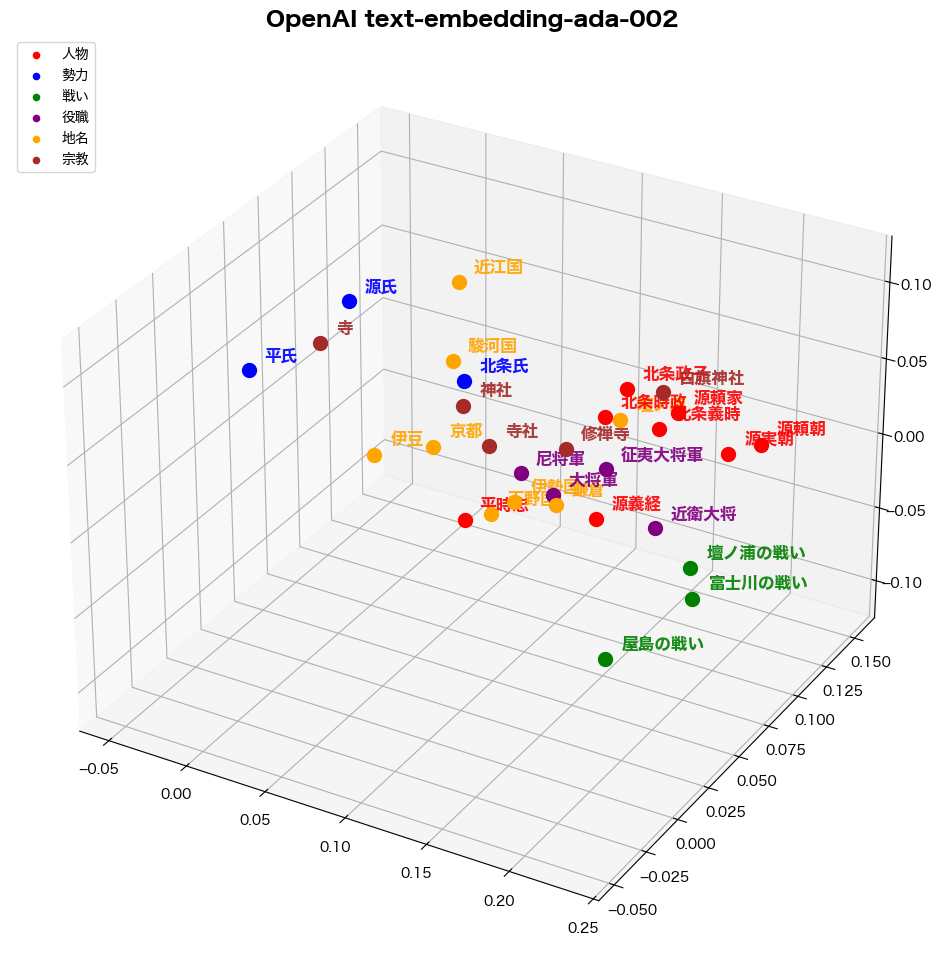

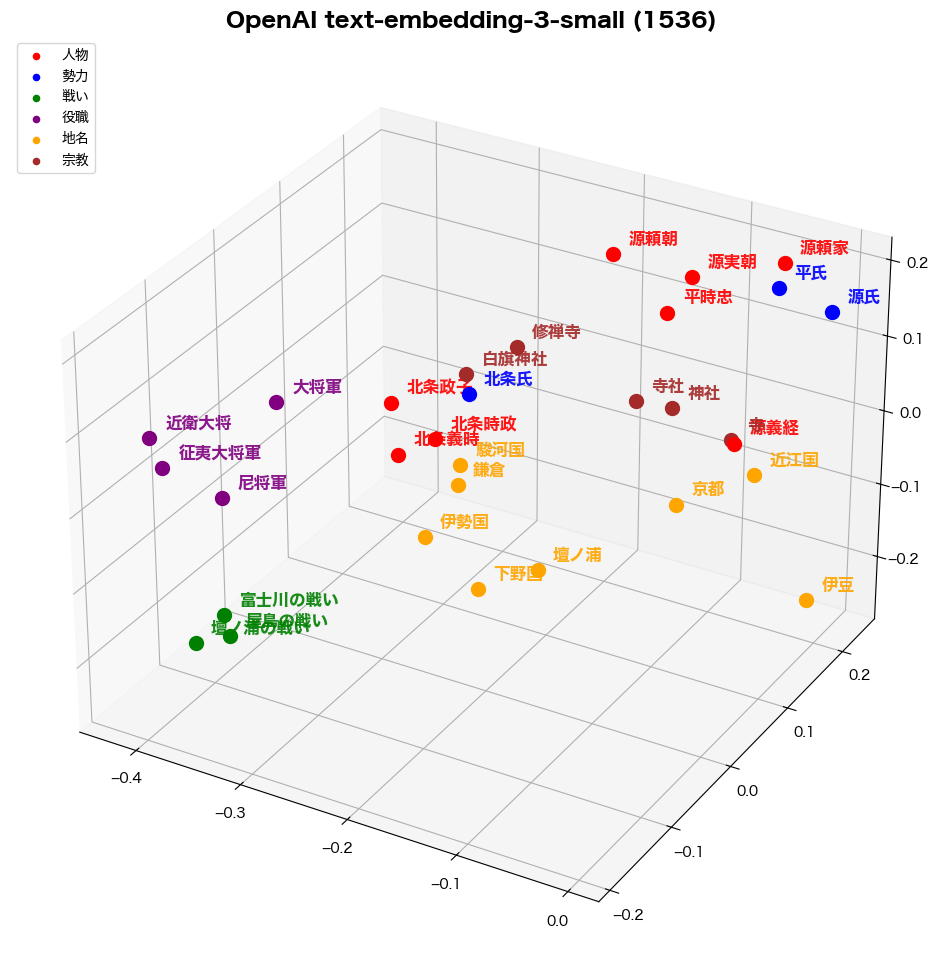

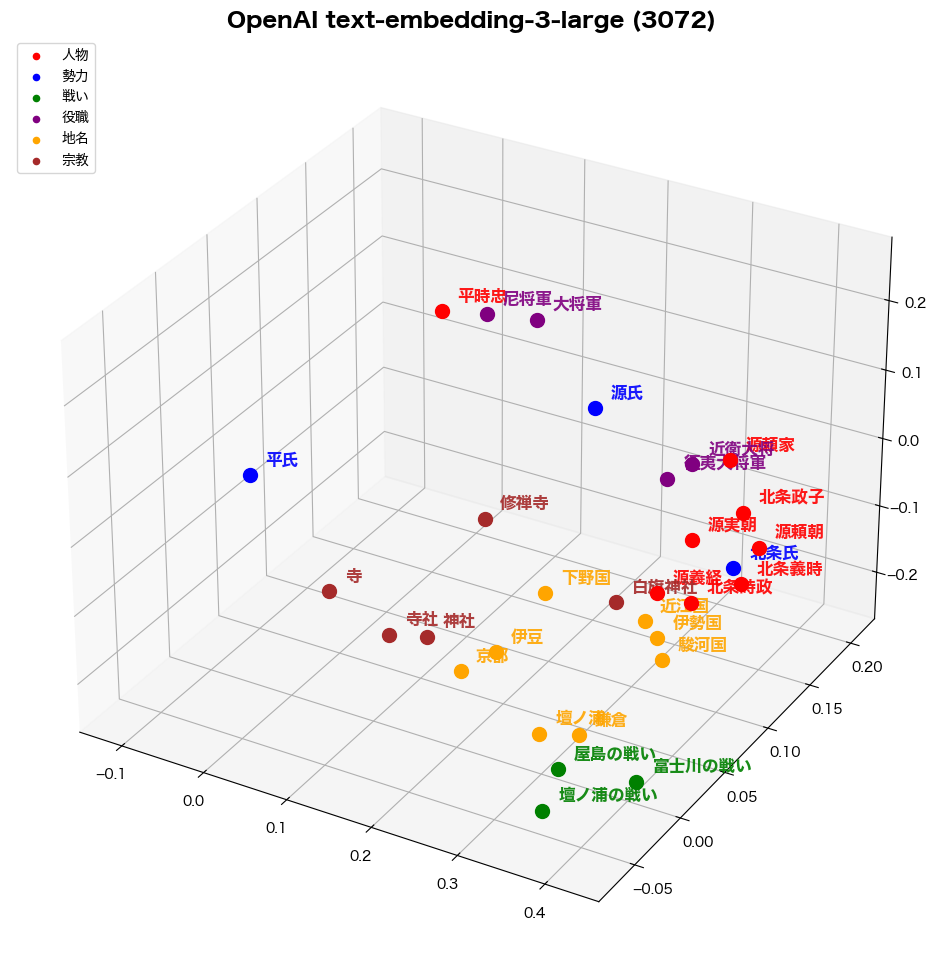

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# フォントの設定（MacOS用）
plt.rcParams['font.family'] = 'Hiragino Sans'

# グループごとに単語を定義
groups = {
    '人物': ['源頼朝', '源義経', '源頼家', '北条政子', '北条義時', '平時忠', '北条時政', '源実朝'],
    '勢力': ['平氏', '源氏', '北条氏'],
    '戦い': ['壇ノ浦の戦い', '屋島の戦い', '富士川の戦い'],
    '役職': ['征夷大将軍', '尼将軍', '近衛大将', '大将軍'],
    '地名': ['鎌倉幕府', '駿河国', '近江国', '伊勢国', '下野国', '京都', '鎌倉', '伊豆', '壇ノ浦' ],
    '宗教': ['寺社', '神社', '寺', '修禅寺', '白旗神社']
}

# グループに応じた色を設定
group_colors = {
    '人物': 'red',
    '勢力': 'blue',
    '戦い': 'green',
    '役職': 'purple',
    '地名': 'orange',
    '宗教': 'brown'
}

def get_group_color(word):
    """単語が属するグループの色を取得"""
    for group, words in groups.items():
        if word in words:
            return group_colors[group]
    return 'gray'  # グループ未定義の場合

def render_vectors_3d(vectors: dict, title: str):
    """Render 3-dimensional vectors (key: [,,,]) in a 3D plot with grouped labeling"""
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    # 軸範囲の自動設定
    min_x = min(v[0] for v in vectors.values())
    max_x = max(v[0] for v in vectors.values())
    min_y = min(v[1] for v in vectors.values())
    max_y = max(v[1] for v in vectors.values())
    min_z = min(v[2] for v in vectors.values())
    max_z = max(v[2] for v in vectors.values())

    # 軸範囲の差分を基にオフセットを動的に設定
    x_offset = (max_x - min_x) * 0.02
    y_offset = (max_y - min_y) * 0.02
    z_offset = (max_z - min_z) * 0.02

    for key, vector in vectors.items():
        color = get_group_color(key)
        # 点をプロット（グループ色を適用）
        ax.scatter(vector[0], vector[1], vector[2], color=color, s=100)  
        # ラベルをポイントの少し上に表示
        ax.text(vector[0] + x_offset, vector[1] + y_offset, vector[2] + z_offset, 
                key, fontsize=12, color=color, alpha=0.9, fontweight='bold')

    # 凡例の作成
    for group, color in group_colors.items():
        ax.scatter([], [], [], color=color, label=group)

    # 軸範囲を設定
    ax.set_xlim([min_x - x_offset, max_x + x_offset])
    ax.set_ylim([min_y - y_offset, max_y + y_offset])
    ax.set_zlim([min_z - z_offset, max_z + z_offset])
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.legend(loc='upper left')
    plt.show()

# Get subset of the vectors for plotting
words = ['壇ノ浦の戦い', '壇ノ浦', '屋島の戦い', '源頼朝', '源義経', '源頼家', '北条政子', '北条義時', 
         '平時忠', '北条時政', '平氏', '源氏', '富士川の戦い', '源実朝', '征夷大将軍', 
         '北条氏', '駿河国', '近江国', '伊勢国', '下野国', '京都', '鎌倉', '伊豆', '寺社', '神社', 
         '寺', '修禅寺', '白旗神社',  '尼将軍', '近衛大将', '大将軍']

word_pca_vectors_ada2 = {word: vectors_ada2_pca[word] for word in words}
word_pca_vectors_emb3 = {word: vectors_emb3_pca[word] for word in words}
word_pca_vectors_emb3_large = {word: vectors_emb3_large_pca[word] for word in words}

# Plot the vectors with improved labeling
render_vectors_3d(word_pca_vectors_ada2, 'OpenAI text-embedding-ada-002')
render_vectors_3d(word_pca_vectors_emb3, 'OpenAI text-embedding-3-small (1536)')
render_vectors_3d(word_pca_vectors_emb3_large, 'OpenAI text-embedding-3-large (3072)')


## 類似度の値の範囲

各埋め込みモデルには異なる類似性の値の範囲があるため、あるモデルにおける類似性が0.5であるからといって、別のモデルにおける類似性が0.5と同じであると想定すべきではありません。使用しているモデルの類似性の値の範囲を必ず確認してください。


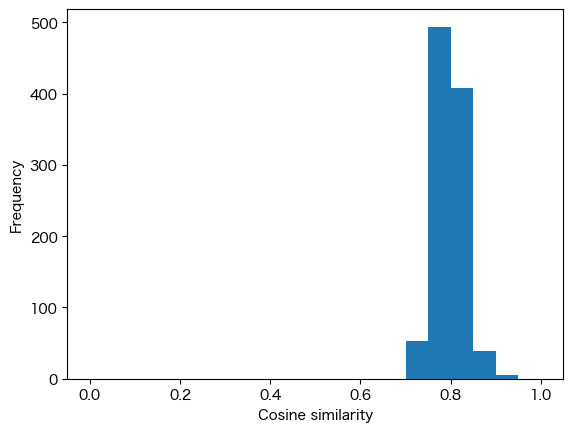

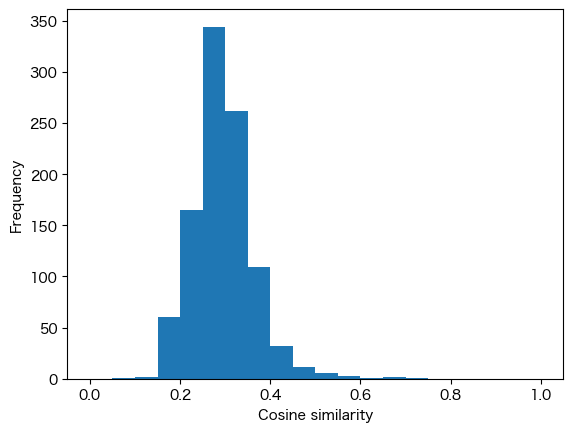

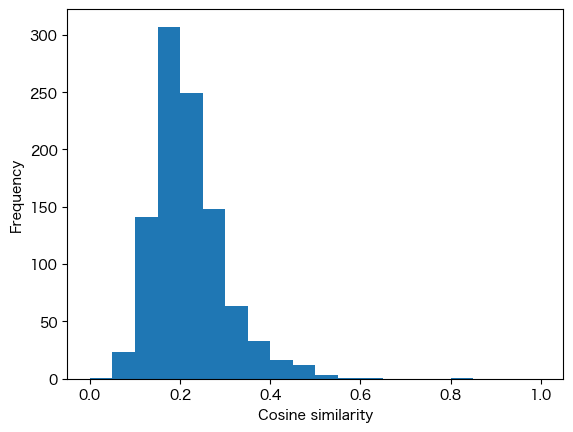

In [12]:
def cosine_similarity_histogram(word: str, vectors: dict):
    """その単語と他のすべての単語とのコサイン類似度をヒストグラムでプロットする"""
    word_vector = vectors[word]
    similarities = [cosine_similarity(word_vector, vectors[w]) for w in vectors if w != word]
    plt.hist(similarities, bins=20, range=(0, 1))
    plt.xlabel('Cosine similarity')
    plt.ylabel('Frequency')
    plt.show()

word = '源頼朝'
cosine_similarity_histogram(word, vectors_ada2)
cosine_similarity_histogram(word, vectors_emb3)
cosine_similarity_histogram(word, vectors_emb3_large)

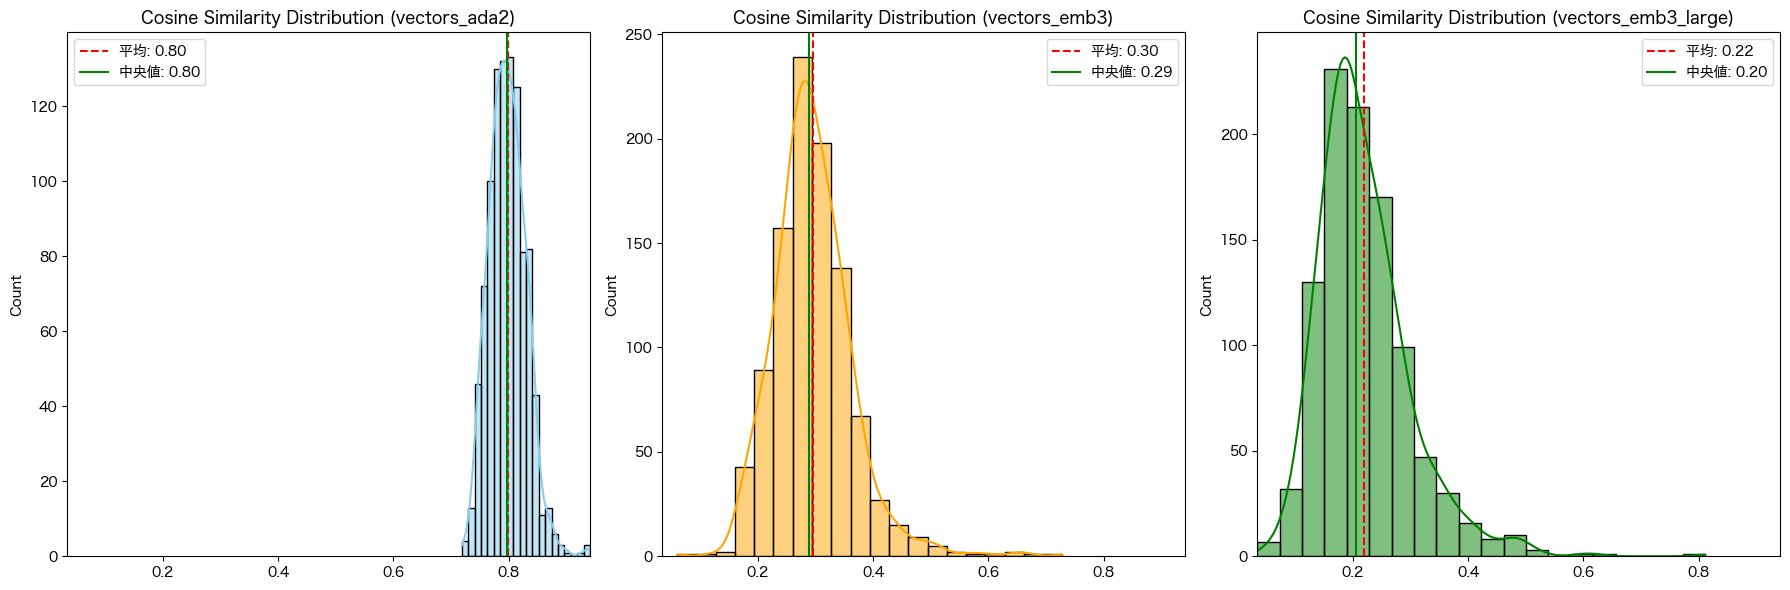

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def cosine_similarity_histogram(word: str, vectors_ada2: dict, vectors_emb3: dict, vectors_emb3_large: dict):
    """Plot histograms and KDE for three vector sets in one figure"""

    def compute_statistics(similarities):
        """Calculate basic statistics."""
        mean = np.mean(similarities)
        median = np.median(similarities)
        return mean, median
    
    # 計算部分
    similarities_ada2 = [cosine_similarity(vectors_ada2[word], vectors_ada2[w]) for w in vectors_ada2 if w != word]
    similarities_emb3 = [cosine_similarity(vectors_emb3[word], vectors_emb3[w]) for w in vectors_emb3 if w != word]
    similarities_emb3_large = [cosine_similarity(vectors_emb3_large[word], vectors_emb3_large[w]) for w in vectors_emb3_large if w != word]

    # x軸範囲の統一（3つのデータセットの範囲の最小値・最大値を取得）
    x_min = min(min(similarities_ada2), min(similarities_emb3), min(similarities_emb3_large))
    x_max = max(max(similarities_ada2), max(similarities_emb3), max(similarities_emb3_large))
    
    # プロットの作成
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 共通設定
    plot_titles = ['vectors_ada2', 'vectors_emb3', 'vectors_emb3_large']
    data_sets = [similarities_ada2, similarities_emb3, similarities_emb3_large]
    colors = ['skyblue', 'orange', 'green']

    for i, (title, data, color) in enumerate(zip(plot_titles, data_sets, colors)):
        # ヒストグラム + KDE
        sns.histplot(data, bins=20, kde=True, ax=axes[i], color=color)
        mean, median = compute_statistics(data)
        axes[i].axvline(mean, color='red', linestyle='--', label=f'平均: {mean:.2f}')
        axes[i].axvline(median, color='green', linestyle='-', label=f'中央値: {median:.2f}')
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_title(f'Cosine Similarity Distribution ({title})')
        axes[i].legend()

    # 全体レイアウト調整
    plt.tight_layout()
    plt.show()

# 使用例
word = '源頼朝'
cosine_similarity_histogram(word, vectors_ada2, vectors_emb3, vectors_emb3_large)
